In [1]:
import torch
from layers import * 
from models import *
from voxel  import voxel2obj
from tqdm import tqdm
from glob import glob
import os, shutil
from torch.utils.data import DataLoader
from pytorch3d.io import load_obj, save_obj
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
from scripts import binvox_rw
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
import scipy.io as sio
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import Voxel_loader
import matplotlib.animation #import FuncAnimation
from matplotlib.animation import FuncAnimation
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
objects = ['bench','cabinet','car','cellphone','chair','lamp','monitor','plane','rifle','sofa','speaker','table','watercraft']
labels = {'04379243':'table','03211117':'monitor','04401088':'cellphone','04530566': 'watercraft',  '03001627' : 'chair','03636649' : 'lamp',  '03691459': 'speaker' ,  '02828884':'bench',
'02691156': 'plane', '02808440': 'bathtub',  '02871439': 'bookcase',
'02773838': 'bag', '02801938': 'basket', '02828884' : 'bench','02880940': 'bowl' ,
'02924116': 'bus', '02933112': 'cabinet', '02942699': 'camera', '02958343': 'car', '03207941': 'dishwasher',
'03337140': 'file', '03624134': 'knife', '03642806': 'laptop', '03710193': 'mailbox',
'03761084': 'microwave', '03928116': 'piano', '03938244':'pillow', '03948459': 'pistol', '04004475': 'printer',
'04099429': 'rocket', '04256520': 'sofa', '04554684': 'washer', '04090263': 'rifle'}

In [3]:
a = ['bench','sofa','chair','lamp','table']
b = ['02828884', '04256520', '03001627', '03636649', '04379243']
[labels[i] for i in b]

['bench', 'sofa', 'chair', 'lamp', 'table']

In [ ]:
destination_path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/GEOMetrics/shapenet/'
source_path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/shapenet_3dr2n2/shapenet_3dr2n2/'

for classes in objects:
    os.makedirs(destination_path+classes, exist_ok=True)

In [ ]:
paths = glob(source_path+'/*/*')

In [ ]:
paths[0]

# Filter Meshes with Vertex < 6,000

In [ ]:
def filter_meshes(pth):
    try:
        cls, obj = labels[pth.split('/')[-2]], pth.split('/')[-1]
        dst_path = os.path.join(destination_path, cls, obj)
        os.makedirs(dst_path, exist_ok=True)
        verts, faces, aux = load_obj(pth+'/model.obj')
        if len(verts)<=20000:
            shutil.copy(pth+'/model.obj', dst_path)
            shutil.copy(pth+'/model.binvox', dst_path)
#             shutil.copy(pth+'/model.mtl', dst_path)
    except:
        print('failed for: ', pth)
        try:
            shutil.rmtree(dst_path)
        except:
            pass

In [ ]:
# pool = Pool(processes=16)
# pbar = tqdm(pool.imap_unordered(filter_meshes, paths), total=len(paths))
# pbar.set_description("Filtering Meshes")
# for _ in pbar:
#     pass

# Distribution of vertex

In [ ]:
dist = np.load('verts_size.npy')

In [ ]:
pd.DataFrame(dist).describe()

# Convert to Voxels

In [ ]:
folders = glob(dest)

In [ ]:
cur_class = ''
for m in tqdm(models):
    with open(m, 'rb') as f:
        try:
            model = binvox_rw.read_as_3d_array(f).data
        except ValueError:
            continue

    # remove internals from models
    # I think this makes it easier to learn
    positions = np.where(model != 0 )
    new_mod = np.zeros(model.shape)
    for i, j, k in zip(*positions):
        # identifies if current voxel has an exposed face
        if np.sum(model[i-1:i+2, j-1:j+2, k-1:k+2]) < 27:
            new_mod[i,j,k] = 1
    # save as np array
    sio.savemat(m.replace('.binvox',''), {'model': new_mod.astype(np.uint8)})

# Remove Empty Directory

In [ ]:
folder_path = glob(destination_path+'/*/*')

In [ ]:
empty = []
for fld in tqdm(folder_path):
    if len(os.listdir(fld)) == 0:
        empty.append(fld)
#         shutil.rmtree(fld)

# Ananlyze Data

In [ ]:
path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/GEOMetrics/shapenet/'
path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/SICGAN_data/'

In [ ]:
train_paths = []
valid_paths = []
for p in glob(path+'/*'):
    print(labels[p.split('/')[-1]])
    cls_pths = glob(p+'/*')
    print('\t',len(cls_pths))

In [ ]:
train_paths = []
valid_paths = []
for p in glob(path+'/*'):
    print(p.split('/')[-1])
    cls_pths = glob(p+'/*')
    ratio = int(len(cls_pths)*.7)
    print('\t',len(cls_pths))

# Visualiza data

In [4]:
def plot_mesh_plt(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    verts = mesh.verts_packed().cpu()
    faces = mesh.faces_packed().cpu()
    x = verts[:,0]
    y = verts[:,1]
    z = verts[:,2]
    i = faces[:,0]
    j = faces[:,1]
    k = faces[:,2]
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.plot_trisurf(x, y, z, triangles = [i,j,k])
    ax.set_title(title)
    ax.view_init(120, 25)
    plt.show()

def load_mesh(tst_obj):
    verts, faces, aux = load_obj(tst_obj)
    mesh = Meshes(verts=[verts], faces=[faces.verts_idx])
    return mesh

from PyGEL3D import gel
from PyGEL3D import js
def plot_mesh(mesh):
    save_obj('mesh.obj', mesh.verts_packed(), mesh.faces_packed())
    js.set_export_mode()
    m = gel.obj_load('mesh.obj')
    js.display(m, smooth=False)

# Check Trained Model

In [5]:
path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/GEOMetrics/shapenet/'
path = glob(path+'/*/*')

In [7]:
enc = MeshEncoderGCN(50)
dec = Decoder(50)
enc.load_state_dict(torch.load('checkpoint/vanilla_gcn_run_lr_0.001_latent_50_final_run/encoder', map_location=torch.device('cpu')))
dec.load_state_dict(torch.load('checkpoint/vanilla_gcn_run_lr_0.001_latent_50_final_run/decoder', map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
objects = ['chair']#['bench','sofa','chair','lamp','table']
path = '/scratch/jiadeng_root/jiadeng/shared_data/datasets/GEOMetrics/shapenet/'
train_paths = []
valid_paths = []

for p in glob(path+'/*'):
    if p.split('/')[-1] in objects:
        cls_pths = glob(p+'/*')        
        ratio = int(len(cls_pths)*.7)
        train_paths += cls_pths[:ratio]
        valid_paths += cls_pths[ratio:]

# load data
train_data = Voxel_loader(train_paths, set_type = 'train')
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn = train_data.collate)

valid_data = Voxel_loader(valid_paths, set_type = 'valid')
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, collate_fn = valid_data.collate)

The number of train set objects found : 3857
The number of valid set objects found : 1654


In [35]:
batch = valid_loader.dataset[110]
voxel_gt = batch['voxels'].unsqueeze(0)
verts, faces, edges, adj, idx = batch['verts'], batch['faces'], batch['edges'], batch['adj'], batch['id']
latent = enc(verts, edges, adj).unsqueeze(0)
# latent = enc(verts, adj).unsqueeze(0)
voxel_pred = dec(latent)
mesh = Meshes(verts=[verts], faces=[faces])
idx

'/scratch/jiadeng_root/jiadeng/shared_data/datasets/GEOMetrics/shapenet/chair/9663b0a707ba9753983e0ae0e9b98f24'

In [36]:
# plot_mesh(mesh)

In [37]:
threshold = 0.2
voxel_pred_ = voxel_pred.clone()
voxel_pred_[voxel_pred > threshold] = 1  
voxel_pred_[voxel_pred<= threshold] = 0

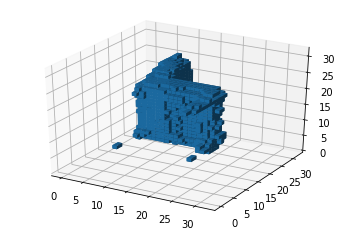

In [39]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxel_pred_.squeeze(0))
plt.show()

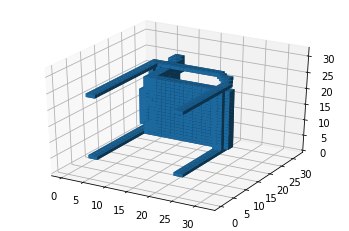

In [40]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxel_gt.squeeze(0))
plt.show()

In [2]:
path = "/scratch/jiadeng_root/jiadeng/shared_data/datasets/SICGAN_data/p2m_splits.json"